# Pre Process Pipeline

## ML

In [31]:
import os
import librosa
import numpy as np
import soundfile as sf
import scipy.signal
import noisereduce as nr
from pydub import AudioSegment
import librosa.display
import matplotlib.pyplot as plt

c:\Users\NoteBook\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\NoteBook\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
# === CONFIGURATION ===
MAIN_FOLDER_PATH = ".."
PRE_PROCESSED_PATH = ".."
DATASET_PATH = os.path.join(MAIN_FOLDER_PATH, "DataSet")
OUTPUT_FOLDER = os.path.join(PRE_PROCESSED_PATH, "PreProcessedDataSet_for_ML")
TARGET_SR = 16000   # sapmle rate
SILENCE_TOP_DB = 35
HIGHPASS_CUTOFF = 85  # cutoff to remove low-frequency noise
VISUALIZATION_DIR = "AudioVisualizations"
N_FFT = 512 # 32 ms window 
HOP_LENGTH = 205 # 12.8 ms step → 60% overlap

os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(VISUALIZATION_DIR, exist_ok=True)

In [33]:
def visualize_audio_features(audio, sr, file_path=None):
    """Generate and save 4 visualizations: Spectrogram, Mel Spectrogram, Chromagram, MFCC Heatmap."""
    base = os.path.splitext(os.path.basename(file_path))[0] if file_path else "audio"

    # Spectrogram
    D = np.abs(librosa.stft(audio))
    DB = librosa.amplitude_to_db(D, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(DB, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format="%+2.0f dB")
    plt.title('Spectrogram')
    plt.tight_layout()
    plt.savefig(f"{VISUALIZATION_DIR}/{base}_spectrogram.png", dpi=300)
    plt.close()

    # Mel Spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format="%+2.0f dB")
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.savefig(f"{VISUALIZATION_DIR}/{base}_mel_spectrogram.png", dpi=300)
    plt.close()

    # Chromagram
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(chroma, y_axis=None, x_axis='time', sr=sr)
    plt.yticks(ticks=np.arange(12), labels=['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
    plt.colorbar()
    plt.title('Chromagram')
    plt.tight_layout()
    plt.savefig(f"{VISUALIZATION_DIR}/{base}_chromagram.png", dpi=300)
    plt.close()

    # MFCC Heatmap
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, n_fft=N_FFT, hop_length=HOP_LENGTH)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time', sr=sr)
    plt.colorbar()
    plt.title('MFCC Heatmap (13 Coefficients)')
    plt.tight_layout()
    plt.savefig(f"{VISUALIZATION_DIR}/{base}_mfcc_heatmap.png", dpi=300)
    plt.close()


### Used Functions For Pre-processing Explained

The reason for using these specific functinsfor our pre-processing pipeline for *traditional ML speech emotion recognition* on the **CREMA-D dataset**:

---

#### **`load_and_resample_audio(file_path, sr=TARGET_SR)`**  
**Reason for using:**  
- Ensures all audio files have the same sampling rate (e.g., 16kHz).  
- Different recordings might have varying sample rates, which makes feature extraction (like MFCC, Chroma, etc.) inconsistent.  
- Having a consistent `sr` allows uniform time and frequency resolution for all extracted features.  

*In short: Without uniform sampling rate, features would not be comparable.*

---

#### **`convert_to_mono(audio)`**  
**Reason for using:**  
- CREMA-D clips can be stereo.  
- Traditional audio feature extraction (MFCC, Chroma, Spectral Contrast) works on mono signals — stereo channels can cause duplication and confusion.  
- Mono conversion simplifies the signal and avoids unnecessary complexity.  

*Mono ensures one clean signal for consistent, meaningful feature extraction.*

---

#### **`trim_silence(audio, top_db=SILENCE_TOP_DB)`**  
**Reason for using:**  
- Light silence trimming (e.g., `top_db=40`) removes long, unnecessary silences at the beginning and end.  
- Long silences would inflate feature lengths or distort statistics (for features like zero-crossing rate or spectral entropy).  
- But trimming is gentle, so we don’t remove emotional pauses inside the speech.  

*Helps keep the audio focused on speech content, improving feature quality.*

---

#### **`normalize_audio(audio)`**  
**Reason for using:**  
- Normalizes audio so that its peak amplitude is 1.  
- Feature extractors are amplitude-sensitive (especially energy-based features).  
- Without normalization, two identical speech samples at different recording volumes could look like different emotional intensities.  
- Peak normalization maintains relative loudness dynamics but makes the scale consistent.  

*Eliminates unwanted loudness variations while preserving natural expressive dynamics.*

---

#### **`apply_highpass_filter(audio, sr, cutoff=HIGHPASS_CUTOFF)`**  
**Reason for using:**  
- Removes low-frequency hums and rumble below 80Hz (e.g., air conditioning noise, mic stand vibrations).  
- These low frequencies are *not useful* for emotion; emotion features live in mid- and high-frequency ranges (pitch, formants, harmonics).  
- Prevents “pollution” of features like MFCC or spectral contrast by meaningless low-frequency noise.  

*Keeps the frequency content clean and relevant for speech emotion features.*


In [34]:
# =================== PREPROCESSING FUNCTIONS ===================

def load_and_resample_audio(file_path, sr=TARGET_SR):
    """Load audio file and resample."""
    audio, sr = librosa.load(file_path, sr=sr)
    return audio, sr

def convert_to_mono(audio):
    """Convert stereo audio to mono."""
    return librosa.to_mono(audio)

def trim_silence(audio, top_db=SILENCE_TOP_DB):
    """Trim leading and trailing silence (if any)."""
    trimmed_audio, _ = librosa.effects.trim(audio, top_db=top_db)
    return trimmed_audio

def normalize_audio(audio):
    """Normalize audio amplitude to peak value of 1."""
    return audio / np.max(np.abs(audio))

def apply_highpass_filter(audio, sr, cutoff=HIGHPASS_CUTOFF):
    """Apply high-pass filter to remove low-frequency noise."""
    sos = scipy.signal.butter(10, cutoff, btype='highpass', fs=sr, output='sos')
    return scipy.signal.sosfilt(sos, audio)

def is_not_empty(audio):
    if np.max(np.abs(audio)) < 1e-5:
        return 0
    return 1



### Functions We Could Have Used But Avoided and Why

The below functions that you will see on the next python cell are the function that we could've used but decided not to use for the following reasons:

#### **Noise Reduction**  

**Why we avoided it:**  
- CREMA-D is a *studio-recorded* dataset with relatively clean audio;  
- Noise reduction algorithms can sometimes distort the natural tone of speech, which is critical for emotion recognition;  
- Risk of over-smoothing, harming features like pitch variance or spectral dynamics that are crucial for emotion detection.

---

#### **Extreme Silence Removal (aggressive trimming)**  

**Why we avoided it:**  
- Too aggressive silence removal could cut natural pauses that carry emotional cues (hesitation, sighs, or dramatic pauses).  
- Emotion detection benefits from subtle prosody and timing variations.  
- We stuck to `top_db=40` light trimming instead.

---

#### **Volume Standardization (RMS normalization)**  

**Why avoided:**  
- RMS normalization can distort amplitude-based features like loudness, which are *strong indicators* of emotion (e.g., anger vs. calm).  
- Peak normalization was chosen to preserve relative dynamics.

---

#### **Band-Pass Filtering (instead of high-pass)**  

**Why avoided:**  
- CREMA-D recordings already have controlled frequency ranges.  
- Over-filtering could remove important frequency components (high frequencies carry stress, low frequencies carry warmth).  
- High-pass filter (80Hz) was enough to clean up low rumble without cutting expressive content.

---

#### **Time-Stretch or Pitch-Shifting (Data Augmentation)**  

These are great for training large neural models but **not suitable** at preprocessing for ML feature extraction.  
- Feature extraction should happen on clean, original audio.  
- Augmentation could introduce bias or misrepresent real emotional cues.


---




In [35]:
# =================== PREPROCESSING FUNCTIONS WE DIDN'T USE ===================

def reduce_noise(audio, sr):
    """Perform noise reduction using spectral gating."""
    return nr.reduce_noise(y=audio, sr=sr)

def aggressive_trim(audio, top_db=20):
    """Remove even quieter silences more aggressively."""
    trimmed_audio, _ = librosa.effects.trim(audio, top_db=top_db)
    return trimmed_audio

def rms_normalize(audio):
    """Normalize based on RMS energy."""
    rms = np.sqrt(np.mean(audio**2))
    return audio / rms

def bandpass_filter(audio, sr, lowcut=80, highcut=8000):
    """Apply band-pass filter."""
    sos = scipy.signal.butter(10, [lowcut, highcut], btype='band', fs=sr, output='sos')
    return scipy.signal.sosfilt(sos, audio)


The following function is the pipeline process. It gets the audio file does all the processing functions we chose that where suitable and important to do and after processing the audio file the file will be saved as a new file in another foler where all the preProcessed .wav files are there.

In [36]:
import librosa.display
import matplotlib.pyplot as plt


def save_the_waveform(audio, file_path, sr):   
   # Note: No padding or truncation — audio length can vary for ML models
   output_file = os.path.join(OUTPUT_FOLDER, os.path.basename(file_path))
   sf.write(output_file, audio, sr)
   print(f"Saved: {output_file}")

   plt.figure(figsize=(10, 3))
   librosa.display.waveshow(audio, sr=sr, alpha=0.6)
   plt.title(f"Waveform: {os.path.basename(file_path)}")
   plt.xlabel("Time (s)")
   plt.ylabel("Amplitude")
   plt.tight_layout()

   # Prepare output path
   os.makedirs("Waveforms", exist_ok=True)
   base_name = os.path.splitext(os.path.basename(file_path))[0]
   output_path = os.path.join("Waveforms", f"{base_name}.png")

   # Save figure
   plt.savefig(output_path)
   plt.close()

In [37]:
def split_audio(audio, sr, base_filename, segment_duration, overlap):
    
    segment_samples = int(sr * segment_duration)
    min_remainder_samples = int(sr * 0.1)

    i = 0
    start = 0
    while start + segment_samples <= len(audio):
        end = start + segment_samples
        chunk = audio[start:end]

        
        chunk_filename = f"{base_filename}_chunk{i+1}.wav"
        chunk_path = os.path.join(OUTPUT_FOLDER, chunk_filename)
        sf.write(chunk_path, chunk, sr)

        i += 1
        start = end - int(sr * overlap)
        

    # Handle last remaining audio (if exist)
    remainder = len(audio) - (start + int(sr * overlap))
    if remainder >= min_remainder_samples:
        chunk = audio[start:]
        padding = segment_samples - len(chunk)
        padded_chunk = np.pad(chunk, (0, padding), mode='constant')
        
        #padded_chunk = normalize_audio(padded_chunk)

        chunk_filename = f"{base_filename}_chunk{i+1}.wav"
        chunk_path = os.path.join(OUTPUT_FOLDER, chunk_filename)
        sf.write(chunk_path, padded_chunk, sr)

In [38]:
# =================== PIPELINE PROCESS FUNCTION ===================
def process_audio_file(file_path):
    """Apply full preprocessing pipeline to a single audio file (for traditional ML)."""
    try:
        print(f"Processing: {file_path}")
        audio, sr = load_and_resample_audio(file_path) 
        if(is_not_empty(audio)):
            audio = convert_to_mono(audio)
            audio = apply_highpass_filter(audio, sr)
            # audio = reduce_noise(audio, sr)
            audio = trim_silence(audio)
            audio = normalize_audio(audio)
            visualize_audio_features(audio, sr, file_path)
            
            split_audio(audio, sr, os.path.basename(file_path), 0.8, 0.4)

    except Exception as error:
        print(f"Error processing {file_path}: {error}")


In [39]:
# =================== MAIN PIPELINE ===================
def preprocess_dataset():
    """Process all audio files in the dataset (traditional ML pipeline)."""
    for filename in os.listdir(DATASET_PATH):
        if filename.lower().endswith(".wav"):
            file_path = os.path.join(DATASET_PATH, filename)
            process_audio_file(file_path)
    print("\nAll audio files have been preprocessed and saved in: ", OUTPUT_FOLDER)

Processing: ..\DataSet\1001_DFA_ANG_XX.wav
Processing: ..\DataSet\1001_DFA_DIS_XX.wav
Processing: ..\DataSet\1001_DFA_FEA_XX.wav
Processing: ..\DataSet\1001_DFA_HAP_XX.wav


KeyboardInterrupt: 

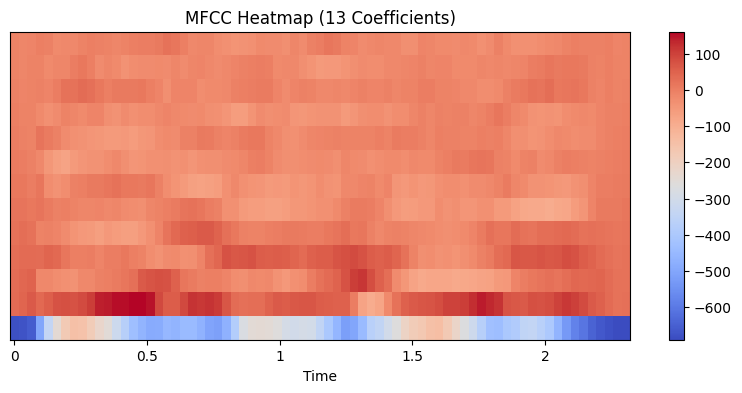

In [40]:
# =================== EXECUTION ===================
preprocess_dataset()